# **Import Libraries**

In [7]:
import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import pymongo
import plotly.express as px

# Get Data
Mongodb version

In [174]:
conn_str = f"mongodb://localhost"
mongo_client = pymongo.MongoClient(conn_str, port=27018)
all_data = pd.DataFrame(mongo_client.done_soon.problems.find({}))
timeout_after_hour = all_data[all_data.time_to_solution > 7199 * 1000]
finishes_before_lower_bound = all_data[all_data.time_to_solution < 30 * 1000]
finishes_after_lower_bound = all_data[all_data.time_to_solution > 30 * 1000]

print(f"Unsolved: {len(timeout_after_hour)}")
print(f"Solved after lower bound: {len(finishes_after_lower_bound) - len(timeout_after_hour)}")
print(f"Solved before lower bound: {len(finishes_before_lower_bound)}")
finishes_after_lower_bound.statistics.map(len).value_counts()

Unsolved: 792
Solved after lower bound: 597
Solved before lower bound: 13485


0      483
15      41
26      35
16      34
20      32
      ... 
96       1
151      1
89       1
189      1
77       1
Name: statistics, Length: 123, dtype: int64

In [155]:
df_5 = []
for id, problem in finishes_after_lower_bound.iterrows():
    for p in problem.statistics:
        percent = round(p["percent"] * 100000, 1)
        if percent == 0:
            new_p = dict(p['features'])
            new_p['mzn'] = problem['mzn']
            new_p['dzn'] = problem['dzn']
            new_p['solved_within_time_limit'] = problem['time_to_solution'] < 7199 * 1000
            df_5.append(new_p)
# df_5
# running_after_6_minutes.statistics.map(lambda x: [y['percent'] for y in x])[0]

In [156]:
len(df_5)
df_5 = pd.DataFrame(df_5)
df_5 = df_5.set_index(["mzn", "dzn"])
df_list = [df_5]


In [157]:
df_5.keys()

Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_sat',
       'decision_level_treesize', 'clause_mem', 'prop_mem',
       'decision_level_mip', 'ewma_decision_level_mip', 'best_objective',
       'ewma_best_objective', 'solved_within_time_limit'],
      dtype='object')

In [158]:
#Calculate additonal features
time_out = 7200 #time in s (or 2hrs)
time_diff = 0.05*time_out

#combined features
for df in df_list:
    df["unassnVar"]   = (2^df.vars) - df.opennodes
    df["fracFailUnassn"]     = df.conflicts / df.unassnVar         # num failures/ num open nodes
    df["fracOpenVisit"]  = (df.vars - df.opennodes) / df.opennodes       # ratio of open nodes to visited nodes (how much of soln space explored)
    df["fracBoolVars"]     = df.boolVars / df.vars                 # num bools / total num of vars
    df["fracPropVars"]     = df.propagations / df.vars        # num propagations/ total num of vars
    df["frac_unassigned"] = df.unassnVar / df.vars  # current assignments/ total vars
    df["fracLongClauses"] = df.long / (df.long + df.bin + df.tern)         # fraction of learnt clauses that have more than 3 literals
    df["freqBackjumps"]  = df.back_jumps/df.search_time
    df.fillna(0, inplace =True)  

'''
#global rate of change features
G_roc_best_objective = [ (df_10.best_objective - df_5.best_objective)/time_diff,
                           (df_15.best_objective - df_10.best_objective)/time_diff,                 
                           (df_20.best_objective - df_15.best_objective)/time_diff]

G_roc_nodes = [ (df_10.nodes - df_5.nodes)/time_diff,
                    (df_15.nodes - df_10.nodes)/time_diff,                 
                    (df_20.nodes - df_15.nodes)/time_diff] 

G_roc_failures = [ (df_10.failures - df_5.failures)/time_diff,
                    (df_15.failures - df_10.failures)/time_diff,                 
                    (df_20.failures - df_15.failures)/time_diff] 

G_roc_backjumps = [ (df_10.back_jumps - df_5.back_jumps)/time_diff,
                    (df_15.back_jumps - df_10.back_jumps)/time_diff,                 
                    (df_20.back_jumps - df_15.back_jumps)/time_diff]

G_roc_propagations = [ (df_10.propagations- df_5.propagations)/time_diff,
                    (df_15.propagations - df_10.propagations)/time_diff,                 
                    (df_20.propagations - df_15.propagations)/time_diff]  

G_roc_solutions = [ (df_10.solutions - df_5.solutions)/time_diff,
                    (df_15.solutions - df_10.solutions)/time_diff,                 
                    (df_20.solutions - df_15.solutions)/time_diff]   

G_roc_restarts = [ (df_10.restarts - df_5.restarts)/time_diff,
                    (df_15.restarts - df_10.restarts)/time_diff,                 
                    (df_20.restarts - df_15.restarts)/time_diff]                                                                              
'''


# add glbal rate of change features to dfs
# count = 0
# for k in [df_10, df_15, df_20]:
#   k["objectiveGROC"] = G_roc_best_objective[count]
#   k["nodesGROC"] = G_roc_nodes[count]
#   k["failureGROC"] = G_roc_failures[count]
#   k["backjumpsGROC"] = G_roc_backjumps[count]
#   k["propagationsGROC"] = G_roc_propagations[count]
#   k["solutionsGROC"] = G_roc_solutions[count]
#   count = count + 1




'\n#global rate of change features\nG_roc_best_objective = [ (df_10.best_objective - df_5.best_objective)/time_diff,\n                           (df_15.best_objective - df_10.best_objective)/time_diff,                 \n                           (df_20.best_objective - df_15.best_objective)/time_diff]\n\nG_roc_nodes = [ (df_10.nodes - df_5.nodes)/time_diff,\n                    (df_15.nodes - df_10.nodes)/time_diff,                 \n                    (df_20.nodes - df_15.nodes)/time_diff] \n\nG_roc_failures = [ (df_10.failures - df_5.failures)/time_diff,\n                    (df_15.failures - df_10.failures)/time_diff,                 \n                    (df_20.failures - df_15.failures)/time_diff] \n\nG_roc_backjumps = [ (df_10.back_jumps - df_5.back_jumps)/time_diff,\n                    (df_15.back_jumps - df_10.back_jumps)/time_diff,                 \n                    (df_20.back_jumps - df_15.back_jumps)/time_diff]\n\nG_roc_propagations = [ (df_10.propagations- df_5.propa

# **Data Analysis**

In [159]:
#distribution of classes
print("Solved | # Problems")
print(df_5["solved_within_time_limit"].value_counts()) 

Solved | # Problems
False    480
True     426
Name: solved_within_time_limit, dtype: int64


In [88]:
#magintude of variables
df_5.describe()

,conflicts,ewma_conflicts,decisions,search_iterations,opennodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,total_time,search_time,intVars,propagations,sat_propagations,ewma_propagations,propagators,boolVars,learnt,bin,tern,long,peak_depth,decision_level_engine,ewma_decision_level_engine,decision_level_sat,decision_level_treesize,clause_mem,prop_mem,decision_level_mip,ewma_decision_level_mip,best_objective,ewma_best_objective,unassnVar,fracOpenVisit,fracBoolVars,fracPropVars,frac_unassigned,fracLongClauses,freqBackjumps
count,855.000000,855.000000,8.550000e+02,8.550000e+02,8.550000e+02,8.550000e+02,8.550000e+02,8.550000e+02,855.000000,855.000000,855.000000,855.000000,855.000000,8.550000e+02,8.550000e+02,8.550000e+02,855.000000,8.550000e+02,855.000000,8.550000e+02,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,8.550000e+02,8.550000e+02,8.550000e+02,855.0,855.0,8.550000e+02,8.550000e+02,855.000000,855.000000,855.000000,8.550000e+02,855.000000,855.000000,855.000000
mean,312788.378947,312769.631310,5.195491e+05,5.475809e+05,1.512034e+05,1.511747e+05,1.516390e+05,1.184077e+05,1.795345,130.506433,360.295234,360.045443,6208.825731,1.373347e+08,6.154398e+08,1.372817e+08,7668.704094,1.454302e+05,62784.936842,1.705624e+04,2757.824561,553.520468,1350.335673,428.860819,437.230304,428.860819,5.475809e+05,5.877965e+04,1.840489e+05,0.0,0.0,2.557045e+06,2.540100e+06,435.781287,0.013348,0.928341,1.079165e+04,0.012610,0.055182,328.884669
std,207306.193755,207305.812551,3.112363e+05,4.449567e+05,3.616626e+05,3.615307e+05,3.616783e+05,2.484635e+05,9.845192,447.163810,0.923419,0.262753,20325.187748,2.764552e+08,1.505718e+09,2.763830e+08,31389.576233,3.530380e+05,27134.346828,9.557076e+04,16891.917431,3615.054619,4275.224239,1274.499467,1276.079325,1274.499467,4.449567e+05,3.005393e+05,7.533498e+05,0.0,0.0,7.343940e+07,7.343982e+07,1279.296264,0.028129,0.070341,7.334930e+04,0.025859,0.193234,690.125963
min,0.000000,0.000000,1.030000e+02,1.000000e+00,1.690000e+02,1.692100e+02,1.800000e+02,0.000000e+00,0.000000,0.000000,360.000924,360.000000,17.000000,6.472500e+04,3.170419e+06,6.349447e+04,3.000000,1.500000e+02,0.000000,0.000000e+00,0.000000,0.000000,2.000000,0.000000,1.740000,0.000000,1.000000e+00,0.000000e+00,7.200000e+01,0.0,0.0,-2.888700e+04,-2.315280e+04,-2.000000,0.000000,0.755218,1.683202e-01,-0.000006,0.000000,0.000000
25%,114059.000000,114040.000000,2.986695e+05,9.189800e+04,1.534800e+04,1.534895e+04,1.553000e+04,1.070000e+03,0.000000,1.000000,360.027189,360.000214,301.000000,2.663778e+07,8.265633e+07,2.641852e+07,388.000000,1.323750e+04,53998.500000,0.000000e+00,0.000000,0.000000,50.500000,13.000000,14.135000,13.000000,9.189800e+04,0.000000e+00,9.312000e+03,0.0,0.0,0.000000e+00,0.000000e+00,12.000000,0.000324,0.865020,2.995659e+02,0.000333,0.000000,2.972172
50%,322331.000000,322312.000000,5.079530e+05,5.124480e+05,2.923000e+04,2.923123e+04,2.997900e+04,2.354900e+04,0.040000,8.000000,360.068684,360.000499,880.000000,6.383244e+07,1.955189e+08,6.382754e+07,1193.000000,2.727300e+04,67125.000000,0.000000e+00,0.000000,0.000000,102.000000,35.000000,37.100000,35.000000,5.124480e+05,0.000000e+00,2.863200e+04,0.0,0.0,5.600000e+01,3.203000e+01,35.000000,0.001124,0.957142,1.835313e+03,0.001112,0.000000,65.413880
75%,483336.500000,483317.500000,6.753260e+05,9.244725e+05,1.279540e+05,1.279428e+05,1.283130e+05,9.285950e+04,0.355000,32.000000,360.162065,360.001132,3662.000000,1.611930e+08,5.102641e+08,1.611751e+08,4163.000000,1.181560e+05,82994.000000,1.725000e+03,306.500000,60.000000,558.500000,205.000000,219.530000,205.000000,9.244725e+05,5.644000e+03,9.991200e+04,0.0,0.0,4.085500e+03,3.136295e+03,220.000000,0.007775,0.989803,7.813344e+03,0.007849,0.015188,257.941449
max,732140.000000,732121.000000,1.516835e+06,1.453473e+06,4.347292e+06,4.347294e+06,4.347318e+06,1.197386e+06,223.480000,3856.000000,369.474876,363.179195,250500.000000,3.814565e+09,1.824418e+10,3.811095e+09,412993.000000,4.280095e+06,99996.000000,1.608122e+06

In [89]:
pd.options.display.max_columns = 999
df_5.loc[df_5.solved_within_time_limit ==1]

conflicts  \
mzn                     dzn                                        
tdtsp/tdtsp.mzn         tdtsp/data/inst_10_58_20.dzn       19833   
mqueens/mqueens2.mzn    mqueens/data/n12.dzn              534329   
                        mqueens/data/n20.dzn              484072   
hrc/hrc.mzn             hrc/data/exp2-1-5600.dzn          217048   
vrplc/vrplc_service.mzn vrplc/data/vrplc9_5_10_s3.dzn     417560   
...                                                          ...   
vrp/vrp.mzn             vrp/data/B-n35-k5.vrp.dzn         373912   
                        vrp/data/A-n39-k5.vrp.dzn         422652   
                        vrp/data/B-n52-k7.vrp.dzn         199240   
                        vrp/data/P-n21-k2.vrp.dzn         689661   
                        vrp/data/B-n34-k5.vrp.dzn         480302   

                                                       ewma_conflicts  \
mzn                     dzn                                             
tdtsp/tdtsp.mzn         tdtsp/data/inst_10_58_20.dzn          19814.0   
mqueens/mqueens2.mzn    mqueens/data/n12.dzn                 534310.0   
                        mqueens/data/n20.dzn                 484053.0   
hrc/hrc.mzn             hrc/data/exp2-1-5600.dzn             217029.0   
vrplc/vrplc_service.mzn vrplc/data/vrplc9_5_10_s3.dzn        417541.0   
...                                                               ...   
vrp/vrp.mzn             vrp/data/B-n35-k5.vrp.dzn            373893.0   
                        vrp/data/A-n39-k5.vrp.dzn            422633.0   
                        vrp/data/B-n52-k7.vrp.dzn            199221.0   
                        vrp/data/P-n21-k2.vrp.dzn            689642.0   
                        vrp/data/B-n34-k5.vrp.dzn            480283.0   

                                                       decisions  \
mzn                     dzn                                        
tdtsp/tdtsp.mzn         tdtsp/data/inst_10_58_20.dzn       20382   
mqueens/mqueens2.mzn    mqueens/data/n12.dzn              536304   
                        mqueens/data/n20.dzn              488231   
hrc/hrc.mzn             hrc/data/exp2-1-5600.dzn          352151   
vrplc/vrplc_service.mzn vrplc/data/vrplc9_5_10_s3.dzn     432758   
...                                                          ...   
vrp/vrp.mzn             vrp/data/B-n35-k5.vrp.dzn         419296   
                        vrp/data/A-n39-k5.vrp.dzn         476071   
                        vrp/data/B-n52-k7.vrp.dzn         367994   
                        vrp/data/P-n21-k2.vrp.dzn         704009   
                        vrp/data/B-n34-k5.vrp.dzn         515633   

                                                       search_iterations  \
mzn                     dzn                                                
tdtsp/tdtsp.mzn         tdtsp/data/inst_10_58_20.dzn               13146   
mqueens/mqueens2.mzn    mqueens/data/n12.dzn                      977694   
                        mqueens/data/n20.dzn                      935968   
hrc/hrc.mzn             hrc/data/exp2-1-5600.dzn                  569200   
vrplc/vrplc_service.mzn vrplc/data/vrplc9_5_10_s3.dzn             763520   
...                                                                  ...   
vrp/vrp.mzn             vrp/data/B-n35-k5.vrp.dzn                 569905   
                        vrp/data/A-n39-k5.vrp.dzn                 648382   
                        vrp/data/B-n52-k7.vrp.dzn                  20375   
                        vrp/data/P-n21-k2.vrp.dzn                 876801   
                        vrp/data/B-n34-k5.vrp.dzn                 404843   

                                                       opennodes  \
mzn                     dzn                                        
tdtsp/tdtsp.mzn         tdtsp/data/inst_10_58_20.dzn      423135   
mqueens/mqueens2.mzn    mqueens/data/n12.dzn                3328   
                        mqueens/data/n20.dzn                9060   
hrc/hr

In [90]:
#Data pre-processing
for df in df_list:
    df.drop(df.columns[df.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df)
    df = pd.DataFrame(transformer.transform(df), columns=df.columns, index=df.index) #normalise data

In [ ]:
features_list = df_list[3].nodes

# **Train Test Split**

In [91]:
# training-testing split
X_train_5, X_test_5, y_train_5, y_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

# X_train_10, X_test_10, y_train_10, y_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

# X_train_15, X_test_15, y_train_15, y_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

# X_train_20, X_test_20, y_train_20, y_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
#X_train, y_train, X_test, y_test  = df_5.drop(columns = ["solved_within_time_limit"]), df_5[["solved_within_time_limit"]],\
#df_5.drop(columns = ["solved_within_time_limit"]), df_5[["solved_within_time_limit"]]
#y_train= np.ravel(y_train)
#y_test= np.ravel(y_test)

In [92]:
y_test_5.value_counts()

True     185
False     29
Name: solved_within_time_limit, dtype: int64

In [93]:
y_train_5.value_counts()

True     577
False     64
Name: solved_within_time_limit, dtype: int64

In [94]:
print(121/127)
print(353/380)

0.952755905511811
0.9289473684210526


# **Import Models**

In [95]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=22)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=22)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=22)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=22)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=22)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
#from sklearn.ensemble import AdaBoostClassifier
#models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=22)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="most_frequent")

# **Feature Importance Analysis**

Feature importance for all features

Large error bars may result from Gini Importance being misleading when features have many unique values 



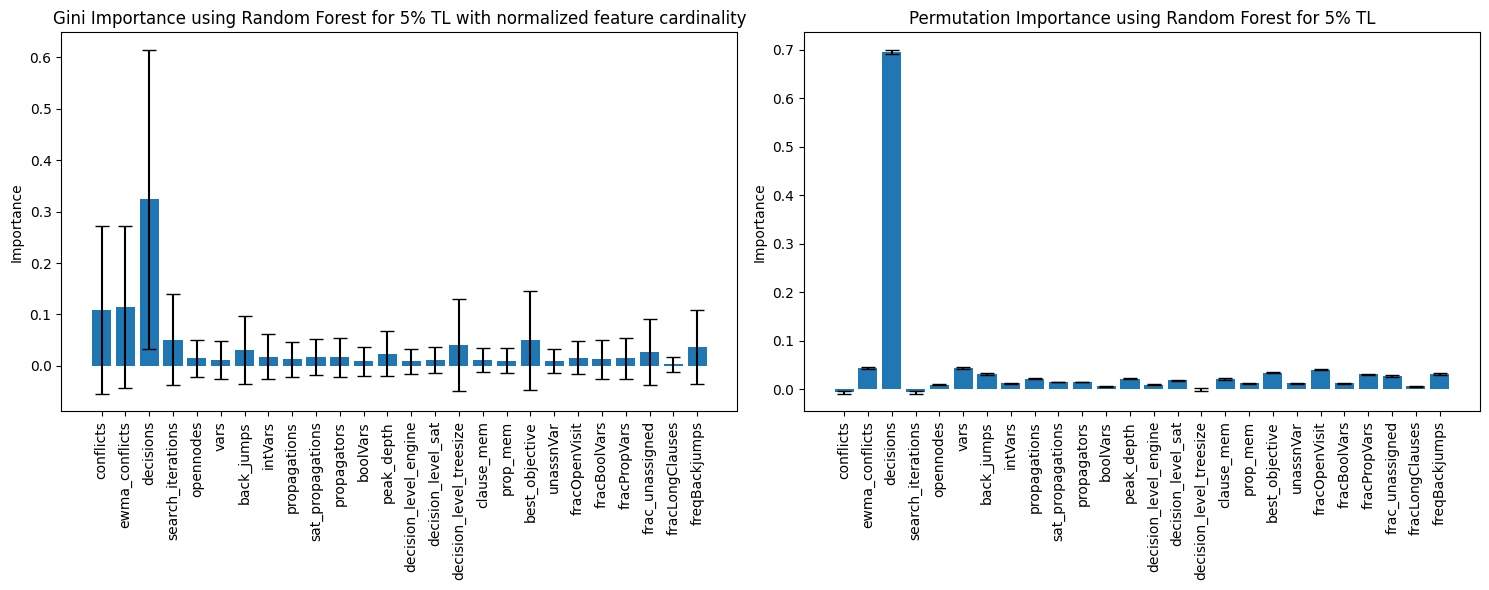

In [96]:
def feat_import_plt(X, y, perc_TL):
  #Display Flags 
  ordered = False   #True displays importances in descending order
  errorbar = True
  cardinality = False

  #Drop values that are neither standard chuffed values nor created
  X = X.drop([      
                "solutions",
                "total_time",
                "search_time", #total time - init time
                "learnt" ,
                "bin",
                "tern",
                "long",
                "ewma_opennodes",
                "ewma_decision_level_engine",
                "ewma_back_jumps",
                "ewma_propagations",
                "ewma_best_objective"], axis=1, inplace=False)
  

  #Feature importance using Gini Impurity
  dcs_t = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_t.fit(X, y)

  importances = dcs_t.feature_importances_
  std = np.std([tree.feature_importances_ for tree in dcs_t.estimators_], axis=0) #get standard dev of importances

  if ordered:
    _sorted_indices = np.argsort(importances)[::-1]   # Sort the feature importance in descending order
  else:
    _sorted_indices = np.array(range(len(importances)))   # unsorted feature importances for comparison

  plt.figure(figsize=(15, 6))
  ax1 = plt.subplot(1, 2, 1)
  plt.title('Gini Importance using Random Forest for '+ perc_TL+'% TL with normalized feature cardinality')
  if not errorbar:
    ax1.bar(range(X.shape[1]), importances[_sorted_indices])
  else :
    ax1.bar(range(X.shape[1]), importances[_sorted_indices], yerr=std, ecolor='black', capsize=5, align='center')
  ax1.set_ylabel('Importance')
  plt.xticks(range(X.shape[1]), X.columns[_sorted_indices], rotation=90)

  #print("GI:", importances[sorted_indices])

  if cardinality:
    c = df_5.apply(pd.Series.nunique) #feature cardinality
    c_array = []
    for i in X.columns[_sorted_indices]:
      c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    
    ax2 = ax1.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

  #Feature importance using Permutation Importance
  perm = permutation_importance(dcs_t, X, y, random_state = 22)
  if ordered:
    _perm_sorted_indices = np.argsort(perm.importances_mean)[::-1] # Sort the feature importance in descending order
  else:
    _perm_sorted_indices = _sorted_indices

  ax3 = plt.subplot(1, 2, 2)
  plt.title('Permutation Importance using Random Forest for '+ perc_TL+'% TL')
  if not errorbar:
    ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10)
  else:
    ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10, yerr=perm.importances_std, ecolor='black', capsize=5, align='center')
  plt.xticks(range(X.shape[1]), X.columns[_perm_sorted_indices], rotation=90)
  ax3.set_ylabel('Importance')

  #print("PI:", perm.importances_mean[perm_sorted_indices])

  if cardinality:
    c_array = []
    for i in X.columns[_perm_sorted_indices]:
      c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    ax2 = ax3.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

  #plt.subplot(1, 3, 3)
  #sns.heatmap(X.corr(), mask = np.triu(X.corr()) )


  plt.tight_layout()
  plt.show()

print("Large error bars may result from Gini Importance being misleading when features have many unique values \n")
feat_import_plt(X_train_5, y_train_5,  "5")
# feat_import_plt(X_train_10, y_train_10, "10")
# feat_import_plt(X_train_15, y_train_15,  "15")
# feat_import_plt(X_train_20, y_train_20,  "20")

Feature importance for proposed (or created) features

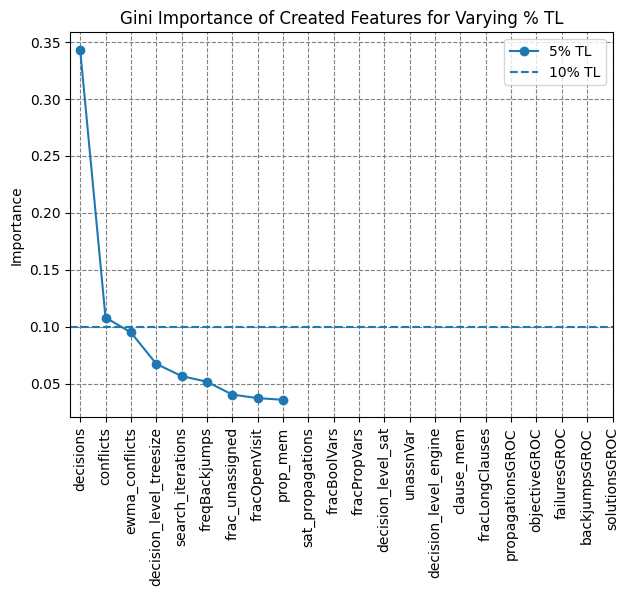

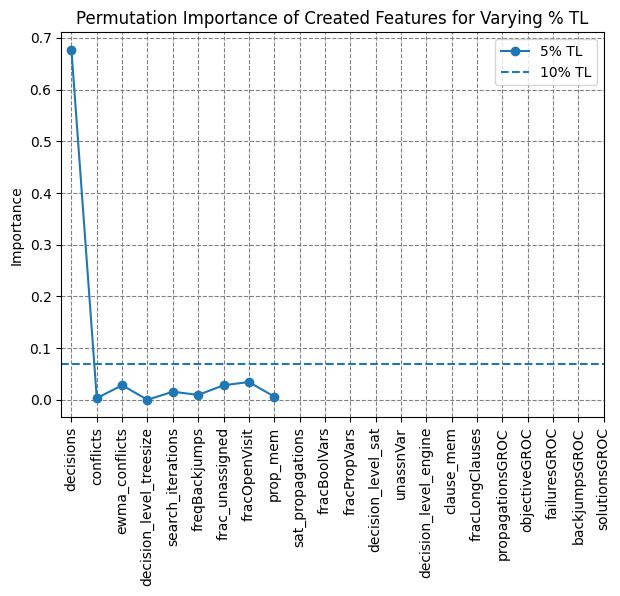

In [103]:
#Only keep proposed features
for df in df_list:
  df.drop([     "opennodes",
                "ewma_opennodes",
                "ewma_decision_level_engine",
                "vars",
                "back_jumps",
                "ewma_back_jumps",
                "solutions",
                "total_time",
                "search_time", #total time - init time
                "intVars",
                "propagations",
                "ewma_propagations",
                "propagators",
                "boolVars",
                "learnt" ,
                "bin",
                "tern",
                "long",
                "peak_depth",
                "best_objective",
                "ewma_best_objective"], axis=1, inplace=True)
  
  
  
#dummy vars for df_5 to match size of other dfs
df_5["objectiveGROC"] = np.zeros(df_5.shape[0])
df_5["failuresGROC"] = np.zeros(df_5.shape[0])
df_5["backjumpsGROC"] = np.zeros(df_5.shape[0])
df_5["propagationsGROC"] = np.zeros(df_5.shape[0])
df_5["solutionsGROC"] = np.zeros(df_5.shape[0])


# Resplit dats into training-testing 
Xd_train_5, Xd_test_5, yd_train_5, yd_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_10, Xd_test_10, yd_train_10, yd_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_15, Xd_test_15, yd_train_15, yd_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_20, Xd_test_20, yd_train_20, yd_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
# #Feature importances using only proposed features
def importance (X, y):
  dcs_5 = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_5.fit(X, y)
  importances_5 = dcs_5.feature_importances_
  std_5 = np.std([tree.feature_importances_ for tree in dcs_5.estimators_], axis=0) #get standard dev of importances
  perm_5 = permutation_importance(dcs_5, X, y, random_state = 22)
  return importances_5, perm_5

[importances_5, perm_5] = importance(Xd_train_5, yd_train_5)
sorted_indices = np.argsort(importances_5)[::-1] 
perm_sorted_indices = np.argsort(perm_5.importances_mean)[::-1] 

# [importances_10, perm_10] = importance(Xd_train_10, yd_train_10)
# sorted_indices_10 = np.argsort(importances_10)[::-1] 
# perm_sorted_indices_10 = np.argsort(perm_10.importances_mean)[::-1]

# [importances_15, perm_15] = importance(Xd_train_15, yd_train_15)
# sorted_indices_15 = np.argsort(importances_15)[::-1] 
# perm_sorted_indices_15 = np.argsort(perm_15.importances_mean)[::-1] 

# [importances_20, perm_20] = importance(Xd_train_20, yd_train_20)
# sorted_indices_20 = np.argsort(importances_20)[::-1] 
# perm_sorted_indices_20 = np.argsort(perm_20.importances_mean)[::-1] 

#Print images
printAll = True #set to flase to show top 10 features

if printAll:
  plt.figure(figsize=(7, 5))
  plt.title('Gini Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], importances_5[sorted_indices][0:9],'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], importances_10[sorted_indices], '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], importances_15[sorted_indices], '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], importances_20[sorted_indices], '-v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Permutation Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], perm_5.importances_mean[sorted_indices][0:9]*10,'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], perm_10.importances_mean[sorted_indices]*10, '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], perm_15.importances_mean[sorted_indices]*10, '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], perm_20.importances_mean[sorted_indices]*10, '-v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])
else:
  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Gini Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:10], importances_5[sorted_indices][0:10],'o' )
  plt.plot(Xd_train_10.columns[sorted_indices_10][0:10], importances_10[sorted_indices_10][0:10], 's')
  plt.plot(Xd_train_15.columns[sorted_indices_15][0:10], importances_15[sorted_indices_15][0:10], '^' )
  plt.plot(Xd_train_20.columns[sorted_indices_20][0:10], importances_20[sorted_indices_20][0:10], 'v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Permutation Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[perm_sorted_indices][0:10], perm_5.importances_mean[perm_sorted_indices][0:10]*10,'o' )
  plt.plot(Xd_train_10.columns[perm_sorted_indices_10][0:10], perm_10.importances_mean[perm_sorted_indices_10][0:10]*10, 's')
  plt.plot(Xd_train_15.columns[perm_sorted_indices_15][0:10], perm_15.importances_mean[perm_sorted_indices_15][0:10]*10, '^' )
  plt.plot(Xd_train_20.columns[perm_sorted_indices_20][0:10], perm_20.importances_mean[perm_sorted_indices_20][0:10]*10, 'v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[perm_sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])


In [108]:
#select top 5 features for training
Xs_train_5  = Xd_train_5.iloc[:, sorted_indices[0:5]]
# Xs_train_10 = Xd_train_10.iloc[:,sorted_indices_10[0:5]]
# Xs_train_15 = Xd_train_15.iloc[:,sorted_indices_15[0:5]]
# Xs_train_20 = Xd_train_20.iloc[:,sorted_indices_20[0:5]]

Xs_test_5  = Xd_test_5.iloc[:,sorted_indices[0:5]]
# Xs_test_10 = Xd_test_10.iloc[:,sorted_indices_10[0:5]]
# Xs_test_15 = Xd_test_15.iloc[:,sorted_indices_15[0:5]]
# Xs_test_20 = Xd_test_20.iloc[:,sorted_indices_20[0:5]]

print("Top 5 features:",Xd_train_5.columns[sorted_indices][0:5])

Top 5 features: Index(['decisions', 'conflicts', 'ewma_conflicts', 'decision_level_treesize',
       'search_iterations'],
      dtype='object')


# **Predictions and Evaluation**

In [109]:
y_test_5

mzn                              dzn                                     
trucking/trucking.mzn            trucking/data/08.dzn                         True
on-call-rostering/oc-roster.mzn  on-call-rostering/data/10s-50d.dzn           True
2DBinPacking/2DPacking.mzn       2DBinPacking/data/Class7_20_7.dzn            True
miplib/assign1-10-4.mzn          NaN                                          True
seat-moving/seat-moving.mzn      seat-moving/data/sm-10-13-00.dzn             True
                                                                             ...  
mrcpsp/mrcpsp.mzn                mrcpsp/data/j30_21_10.dzn                    True
miplib/air04.mzn                 NaN                                         False
wordpress/wordpress.mzn          wordpress/data/Wordpress11_Offers500.dzn     True
nside/full.mzn                   nside/data/HARD_200_50.dzn                   True
miplib/mik-250-20-75-4.mzn       NaN                                          True
Name: solved_

In [110]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
          
          #To Display
          RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0])
          axs[1].bar(key, accuracy[key]) 
          axs[2].bar(key, train_accuracy[key]) 
          axs[3].bar(key, recall[key])
          axs[4].bar(key, precision[key])
          axs[5].bar(key, f1[key])

  axs[0].set_title("ROC Curve for "+perc_TL+"% TL")
  #axs[0].set_ylabel("Accuracy")

  axs[1].set_title("Test Accuracy for "+perc_TL+"% TL")
  axs[1].set_xticklabels(models.keys(),rotation=60)
  axs[1].set_ylabel("Accuracy")
  axs[1].grid(axis='y', color='gray', linestyle='dashed')

  axs[2].set_title("Train Accuracy for "+perc_TL+"% TL")
  axs[2].set_xticklabels(models.keys(),rotation=60)
  axs[2].set_ylabel("Accuracy")
  axs[2].grid(axis='y', color='gray', linestyle='dashed')

  axs[3].set_title("Recall for "+perc_TL+"% TL")
  axs[3].set_xticklabels(models.keys(),rotation=60)
  axs[3].set_ylabel("Recall")
  axs[3].grid(axis='y', color='gray', linestyle='dashed')


  axs[4].set_title("Precision "+perc_TL+"% TL")
  axs[4].set_xticklabels(models.keys(),rotation=60)
  axs[4].set_ylabel("F1")
  axs[4].grid(axis='y', color='gray', linestyle='dashed')

  axs[5].set_title("F1 "+perc_TL+"% TL")
  axs[5].set_xticklabels(models.keys(),rotation=60)
  axs[5].set_ylabel("F1")
  axs[5].grid(axis='y', color='gray', linestyle='dashed')
  figs.show()   

/tmp/ipykernel_56966/2066707389.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_56966/2066707389.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_56966/2066707389.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_56966/2066707389.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_56966/2066707389.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[5].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_56966/2066707389.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show th

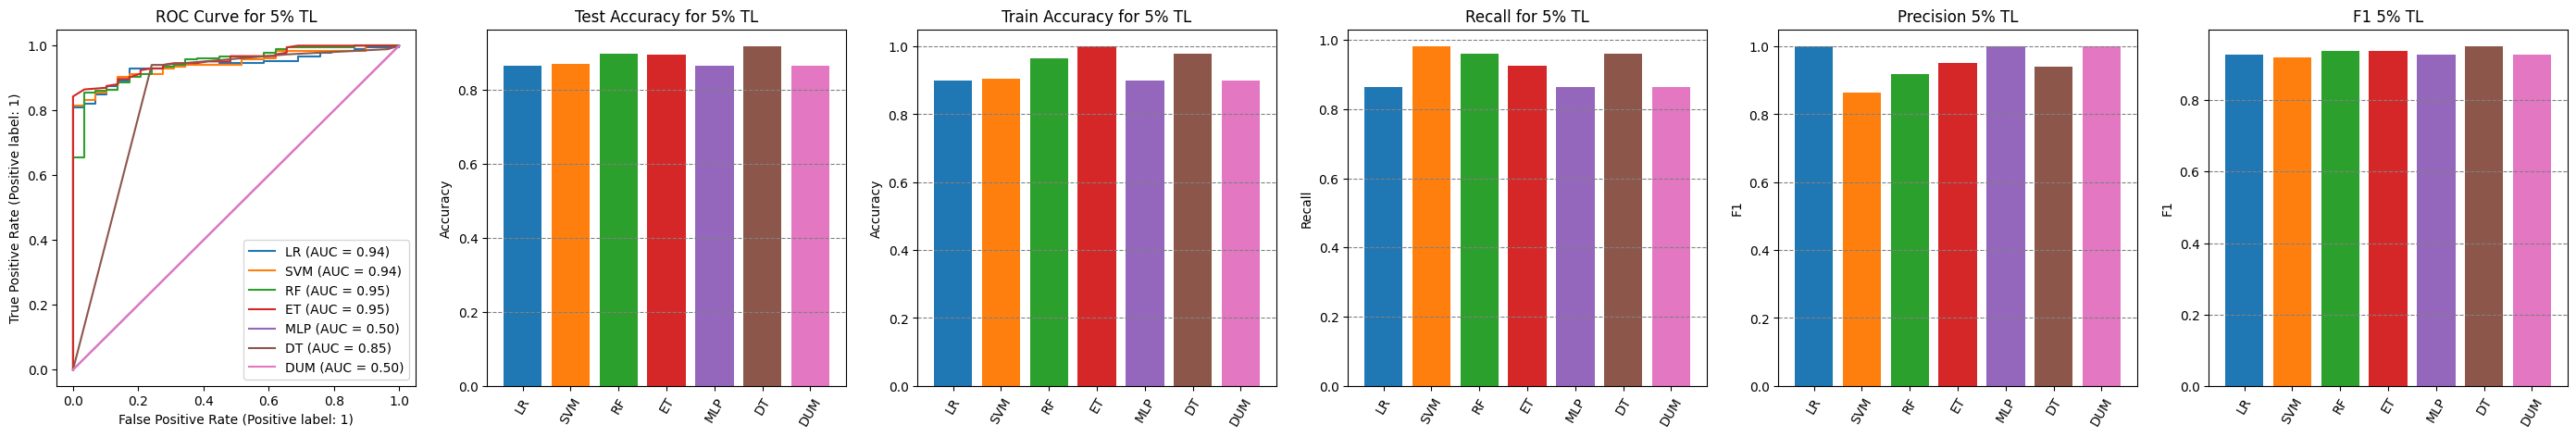

In [111]:
#Bar plot results  for testing and training using top 5 created features
results_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
# results_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
# results_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
# results_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

In [112]:
def results_line_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  #figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
  print("\n------------------------------------------------------------------------")
  print(perc_TL+"% TL train acc:", np.round(list(train_accuracy.values()),2))
  print(perc_TL+"% TL test acc :", np.round(list(accuracy.values()),2))
  print(perc_TL+"% TL precision:",  np.round(list(precision.values()),2))
  print(perc_TL+"% TL recall   :",  np.round(list(recall.values()),2))
  print(perc_TL+"% TL F1       :",  np.round(list(f1.values()),2))
  print(perc_TL+"% TL ROC AUC  :",  np.round(list(auc.values()),2))
  print("------------------------------------------------------------------------")
  return train_accuracy, accuracy, precision, recall, auc, f1

  



------------------------------------------------------------------------
5% TL train acc: [0.9  0.9  0.96 1.   0.9  0.98 0.9 ]
5% TL test acc : [0.86 0.87 0.9  0.89 0.86 0.92 0.86]
5% TL precision: [1.   0.86 0.92 0.95 1.   0.94 1.  ]
5% TL recall   : [0.86 0.98 0.96 0.93 0.86 0.96 0.86]
5% TL F1       : [0.93 0.92 0.94 0.94 0.93 0.95 0.93]
5% TL ROC AUC  : [0.94 0.94 0.95 0.95 0.5  0.85 0.5 ]
------------------------------------------------------------------------


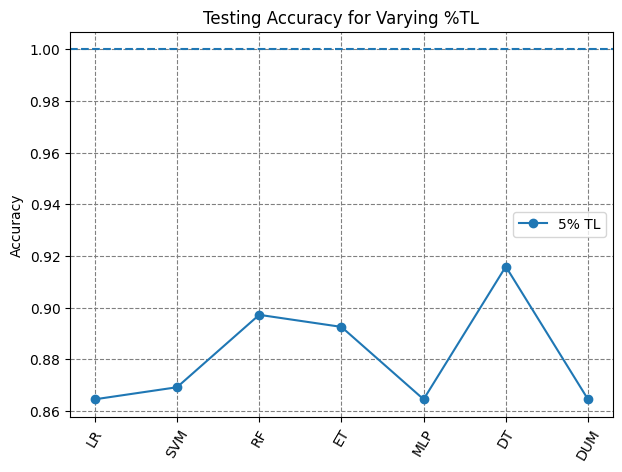

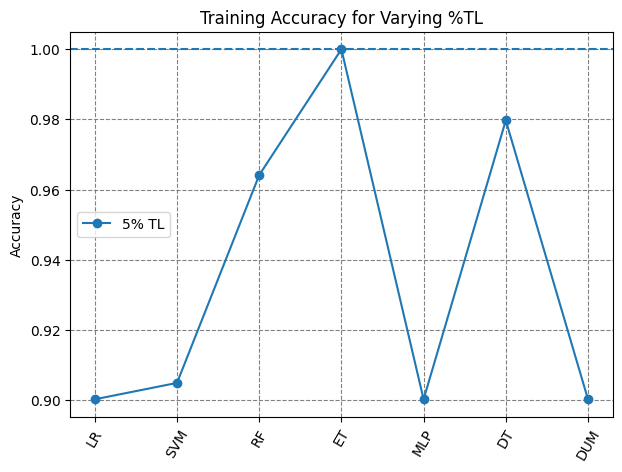

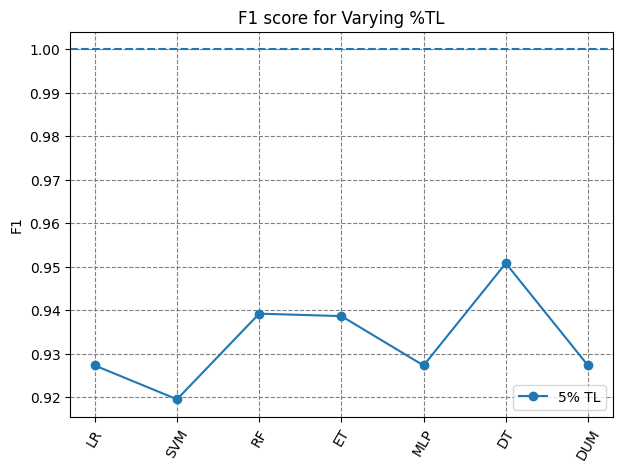

In [114]:

#Line plot results  for testing and training using top 5 created features
train_accuracy_5, accuracy_5, precision_5, recall_5, auc_5, f1_5 = results_line_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
# train_accuracy_10, accuracy_10, precision_10, recall_10, auc_10, f1_10 = results_line_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
# train_accuracy_15, accuracy_15, precision_15, recall_15, auc_15, f1_15 = results_line_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
# train_accuracy_20, accuracy_20, precision_20, recall_20, auc_20, f1_20 = results_line_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

plt.figure(figsize=(7, 5))
plt.title("Testing Accuracy for Varying %TL")
plt.plot(list(accuracy_5.keys()), list(accuracy_5.values()), '-o') 
# plt.plot(list(accuracy_10.keys()), list(accuracy_10.values()), '-s') 
# plt.plot(list(accuracy_15.keys()), list(accuracy_15.values()), '-^') 
# plt.plot(list(accuracy_20.keys()), list(accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("Training Accuracy for Varying %TL")
plt.plot(list(train_accuracy_5.keys()), list(train_accuracy_5.values()),'-o') 
# plt.plot(list(train_accuracy_10.keys()), list(train_accuracy_10.values()), '-s') 
# plt.plot(list(train_accuracy_15.keys()), list(train_accuracy_15.values()), '-^') 
# plt.plot(list(train_accuracy_20.keys()), list(train_accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("F1 score for Varying %TL")
plt.plot(list(f1_5.keys()), list(f1_5.values()),'-o') 
# plt.plot(list(f1_10.keys()), list(f1_10.values()), '-s') 
# plt.plot(list(f1_15.keys()), list(f1_15.values()), '-^') 
# plt.plot(list(f1_20.keys()), list(f1_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('F1')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.show() 

In [115]:
rf_reg = RandomForestClassifier(min_samples_leaf = 5)
rf_reg.fit(X_train_20,y_train_20)
predictions=rf_reg.predict(X_test_20)
print('f1 score is', f1_score(y_test_20,predictions))


importances = rf_reg.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(X_train_20.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_20.shape[1]), X_train_20.columns[sorted_indices], rotation=90)
plt.show()

NameError: name 'X_train_20' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_test_5,predictions)
plot_confusion_matrix(rf_reg, X_test_20, y_test_20)

In [ ]:
df_20.describe()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(min_samples_leaf = 5)
scores = cross_val_score(rf, df_20.drop('solved_within_time_limit', axis=1), df_20['solved_within_time_limit'], cv=5, scoring='f1')
scores

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True)
X = df_20.drop('solved_within_time_limit', axis=1)
y = df_20['solved_within_time_limit']
for train, test in skf.split(X, y):
    rf = RandomForestClassifier(min_samples_leaf = 5)
    rf.fit(X.iloc[train], y.iloc[train])
    pred = rf.predict(X.iloc[test])
    print(len(y.iloc[test][y == 1]))
    print(f1_score(y.iloc[test], pred))
    plot_confusion_matrix(rf, X.iloc[test], y.iloc[test])